In [1]:
import numpy as np
from scipy.optimize import fmin_cobyla
from matplotlib import pylab as plt

import optimizers
from importlib import reload

In [2]:
def f(x, args):
    np.random.seed(args['seed'])
    xi = args['sigma'] * np.random.standard_normal(1)
    return 1./2 * x.T @ args['A'] @ x - args['b'].T @ x + xi

def gradient_true(x, args):
    return args['A'] @ x - args['b']

def calculate(args, optimizer, R_0, label, title):
    
    w_sol, errors, times = optimizer.search()
    iterations = range(1, len(errors)+1)
    
    return iterations, errors / R_0, label, times, w_sol

def momentum_k(k, f, nabla_f, x_k, args):
    return k / (k + 1)

In [13]:
args = {}
args['d'] = 100
args['mu'] = 1
args['L'] = 1000
args['func'] = f
args['seed'] = 42

args['gamma'] = lambda k: 1 / np.sqrt(k + 1)
args['eps'] = -100
args['sigma'] = 0
args['criterium'] = 'f(x_k) - f(x^*)'

args['A'] = optimizers.generate_A(args['d'], args['mu'], args['L'], args['seed'])
np.random.seed(args['seed'])
args['b'] = np.random.random_sample(args['d'])
#args['b'] = np.zeros(args['d'])
args['oracle_counter'] = 0
args['oracle_calls'] = []

In [14]:
reload(optimizers)

def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / (args['c'] * args['L'])

def fw_step(k, func, nabla_f, x_curr, args):
    return args['c_fw'] / (k + 3)

def momentum_fw(k, f, nabla_f, x_k, args):
    return (k + 1) / (k + 3)

args['momentum_k'] = momentum_fw
args['max_steps'] = 10 ** 5
args['batch_size'] = 1
args['use_proj'] = False
args['criterium'] = 'f(x_k+1) - f(x_k)'
np.random.seed(args['seed'])
w_0 = np.random.random_sample(args['d'])
args['jaguar'] = False
args['sega'] = False
args['use_proj'] = True
args['c'] = 50

### l_1 ball ###
args['set'] = 'l1_ball'
w_0_l1 = w_0 / np.linalg.norm(w_0, ord=1)
w_true_sol_l1, _ , _ = optimizers.GDOptimizer(f, gradient_true, 
                                                x_0 = w_0_l1,
                                                step = const_gamma, 
                                                args = args).search()
R_0_l1 = f(w_0_l1, args) - f(w_true_sol_l1, args)

### l_2 ball ###
args['set'] = 'l2_ball'
w_0_l2 = w_0 / np.linalg.norm(w_0, ord=2)
w_true_sol_l2, _ , _ = optimizers.GDOptimizer(f, gradient_true, 
                                                x_0 = w_0_l2,
                                                step = const_gamma, 
                                                args = args).search()
R_0_l2 = f(w_0_l2, args) - f(w_true_sol_l2, args)

### simplex ###
args['set'] = 'simplex'
w_0_simp = np.abs(w_0) / np.linalg.norm(w_0, ord=1)
w_true_sol_simp, _ , _ = optimizers.GDOptimizer(f, gradient_true, 
                                                x_0 = w_0_simp,
                                                step = const_gamma, 
                                                args = args).search()
R_0_simp = f(w_0_simp, args) - f(w_true_sol_simp, args)
args['use_proj'] = False

100%|██████████| 100000/100000 [00:14<00:00, 6791.42it/s]


# TPF

In [134]:
args['norm'] = 1
def fw_step(k, func, nabla_f, x_curr, args):
    if 1 / (k + 3) > 1. / (args['d'] * args['L']):
        return 1. / (args['d'] * args['L'])
    else:
        return 1. / (args['d'] * args['L'])
def momentum_k(k, f, nabla_f, x_k, args):
    return (k + 1) / (k + 3)

In [230]:
reload(optimizers)
title = ''

args['max_steps'] = 4 * 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['sega'] = False
args['prob'] = 0
args['y_k'] = np.zeros(args['d'])

def momentum_fw(k, f, nabla_f, x_k, args):
    return 1

def fw_step(k, func, nabla_f, x_curr, args):
    if 1 / (k + 3) > 1. / (40 * args['L']):
        return 1. / (30 * args['L'])
    else:
        return 1 / (k + 3)

args['momentum_k'] = momentum_fw

args['is'] = []

Q = 'l1_ball'
jaguar = optimizers.get_grad_tpf_jaguar
lame = optimizers.get_grad_tpf_lame_v1
name = 'TPF'

w_0 = w_0_l1
R_0 = R_0_l1
w_sol = w_true_sol_l1

args['h'] = optimizers.get_grad_tpf_lame_v2(w_0, args)
args['grad_curr'] = optimizers.get_grad_tpf_lame_v2(w_0, args)

mbfw_jaguar = optimizers.MBFWOptimizer(f, jaguar, x_0 = w_0, 
                                       step = fw_step, args = args)
mbfw_lame = optimizers.MBFWOptimizer(f, lame, x_0 = w_0,
                                     step = fw_step, args = args)
fw = optimizers.FWOptimizer(f, lame, x_0 = w_0, 
                            step = fw_step, args = args)
proj = optimizers.GDOptimizer(f, lame, x_0 = w_0, 
                              step = const_gamma, args = args)
methods = [mbfw_jaguar, mbfw_lame, fw, proj]
methods = [mbfw_jaguar, proj]
names = ['MBFW jaguar', 'MBFW lame', 'FW', 'Proj']
names = ['MBFW jaguar', 'Proj']

iterations_l1_tpf = []
errors_l1_tpf = []
labels_l1_tpf = []

for method, name in zip(methods, names):
                                  
    args['x_sol'] = w_sol
    args['set'] = Q
    args['oracle_calls'] = []
    args['oracle_counter'] = 0
    if name == 'MBFW jaguar':
        args['jaguar'] = True
        args['sega'] = False
        args['batch_size'] = 1
    else:
        args['sega'] = False
        args['jaguar'] = False
        args['batch_size'] = 1
    if name == 'Proj':
        args['use_proj'] = True
    else:
        args['use_proj'] = False 
    if name == 'MD':
        args['c'] = 1
    elif name == 'MBFW jaguar':
        args['c'] = 10
    else:
        args['c'] = 0.1

    label = f'{name}'

    iterations, errors, _, _, _ = calculate(args, method, R_0, label, title)
    iterations_l1_tpf.append(iterations)
    errors_l1_tpf.append(errors)
    labels_l1_tpf.append(label)

100%|██████████| 40000/40000 [00:06<00:00, 6479.11it/s]


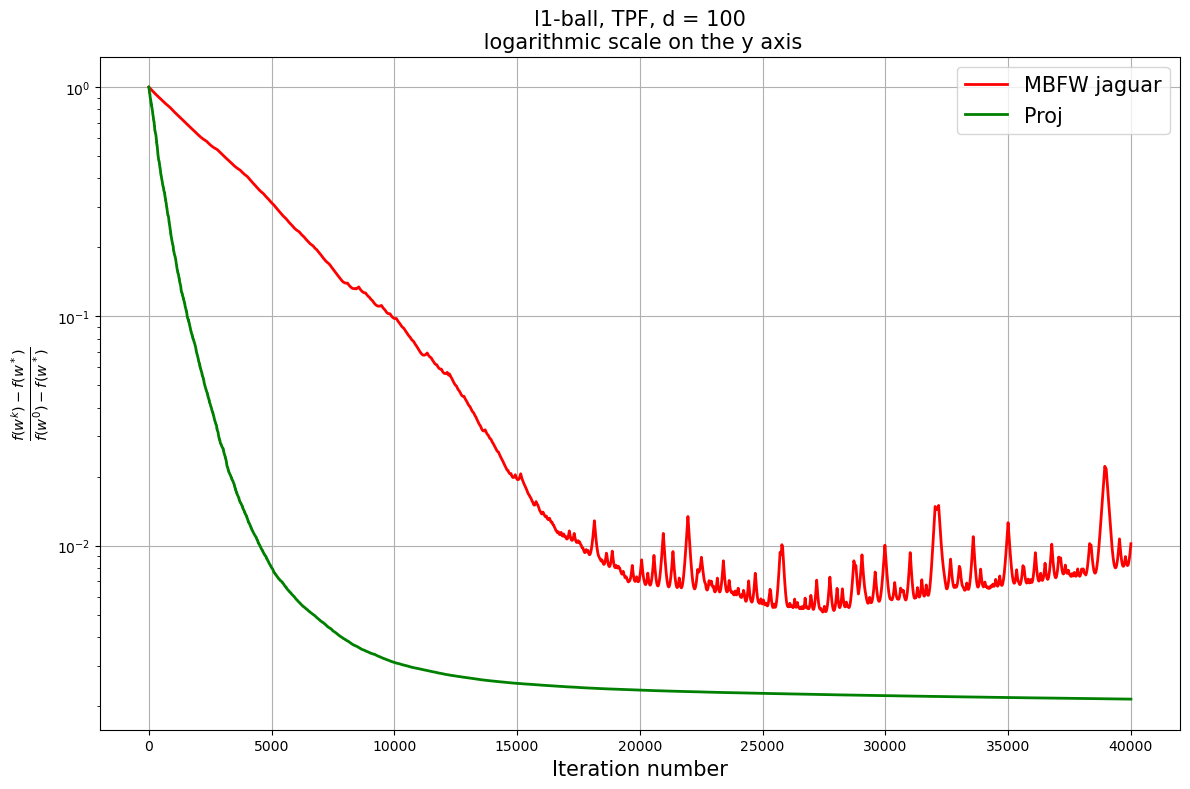

In [229]:
title = f"l1-ball, TPF, d = {args['d']}"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_l1_tpf, errors_l1_tpf, y_label=y_label,
                         labels=labels_l1_tpf, title=title, markers=[None]*100)

НЕ ТРОГАТЬ

In [166]:
reload(optimizers)
def fw_step(k, func, nabla_f, x_curr, args):
    if 1 / (k + 3) > 1. / (args['L']):
        return 1. / (10 * args['L'])
    else:
        return 1 / (k + 3)

args['max_steps'] = 10 * 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['sega'] = True
args['prob'] = 0
args['y_k'] = np.zeros(args['d'])
args['grad_curr'] = np.zeros(args['d'])
args['h'] = np.zeros(args['d'])
args['eps'] = 1e-8

Q = 'l2_ball'
jaguar = optimizers.get_grad_tpf_jaguar
lame = optimizers.get_grad_tpf_lame_v1
name = 'TPF'

w_0 = w_0_l2
R_0 = R_0_l2
w_sol = w_true_sol_l2

mbfw_jaguar = optimizers.MBFWOptimizer(f, jaguar, x_0 = w_0, 
                                         step = fw_step, args = args)
mbfw_lame = optimizers.MBFWOptimizer(f, lame, x_0 = w_0, 
                                         step = fw_step, args = args)
fw = optimizers.FWOptimizer(f, lame, x_0 = w_0, 
                                         step = fw_step, args = args)
proj = optimizers.GDOptimizer(f, lame, x_0 = w_0, 
                                         step = const_gamma, args = args)
methods = [mbfw_jaguar, mbfw_lame, fw, proj]
names = ['MBFW jaguar', 'MBFW lame', 'FW', 'Proj']

iterations_l2_tpf = []
errors_l2_tpf = []
labels_l2_tpf = []

for method, name in zip(methods, names):
                                  
    args['x_sol'] = w_sol
    args['set'] = Q
    args['oracle_calls'] = []
    args['oracle_counter'] = 0
    if name == 'MBFW jaguar':
        args['jaguar'] = True
        args['sega'] = False
        args['batch_size'] = 1
    else:
        args['jaguar'] = False
        args['sega'] = False
        args['batch_size'] = 1
    if name == 'Proj':
        args['use_proj'] = True
    else:
        args['use_proj'] = False 
    if name == 'MD':
        args['c'] = 1
    else:
        args['c'] = 0.1

    label = f'{name}'

    iterations, errors, _, _, _ = calculate(args, method, R_0, label, title)
    iterations_l2_tpf.append(iterations)
    errors_l2_tpf.append(errors)
    labels_l2_tpf.append(label)

100%|██████████| 100000/100000 [00:15<00:00, 6293.00it/s]


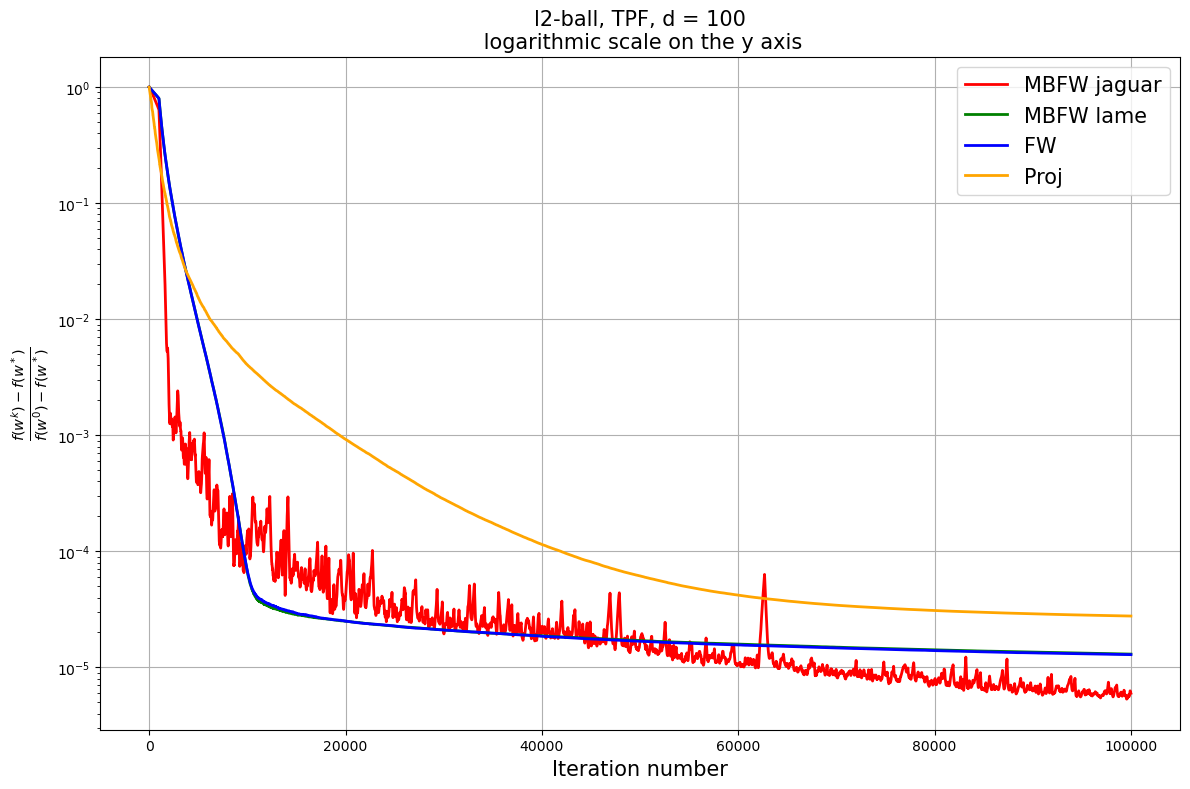

In [167]:
title = f"l2-ball, TPF, d = {args['d']}"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_l2_tpf, errors_l2_tpf, y_label=y_label,
                     labels=labels_l2_tpf, title=title, markers=[None]*100)

In [260]:
reload(optimizers)
title = ''

def fw_step(k, func, nabla_f, x_curr, args):
    return 1 / (k + 3)

args['max_steps'] = 10 ** 6
args['criterium'] = 'f(x_k) - f(x^*)'
args['sega'] = True
args['prob'] = 0
args['y_k'] = np.zeros(args['d'])
args['grad_curr'] = np.zeros(args['d'])
args['h'] = np.zeros(args['d'])
args['norm'] = 1

Q = 'simplex'
jaguar = optimizers.get_grad_tpf_jaguar
lame = optimizers.get_grad_tpf_lame_v1
name = 'TPF'

w_0 = w_0_simp
R_0 = R_0_simp
w_sol = w_true_sol_simp

mbfw_jaguar = optimizers.MBFWOptimizer(f, jaguar, x_0 = w_0, 
                                         step = fw_step, args = args)
mbfw_lame = optimizers.MBFWOptimizer(f, lame, x_0 = w_0, 
                                         step = fw_step, args = args)
fw = optimizers.FWOptimizer(f, lame, x_0 = w_0, 
                                         step = fw_step, args = args)
proj = optimizers.GDOptimizer(f, lame, x_0 = w_0,
                              step = const_gamma, args = args)

md = optimizers.MDOptimizer(f, lame, x_0 = w_0, 
                            step = const_gamma, args = args)

methods = [mbfw_jaguar, mbfw_lame, fw, proj, md]
names = ['MBFW jaguar', 'MBFW lame', 'FW', 'Proj']

iterations_simp_tpf = []
errors_simp_tpf = []
labels_simp_tpf = []

for method, name in zip(methods, names):
                                  
    args['x_sol'] = w_sol
    args['set'] = Q
    args['oracle_calls'] = []
    args['oracle_counter'] = 0
    if name == 'Proj':
        args['use_proj'] = True
    else:
        args['use_proj'] = False 
    if name == 'MD':
        args['c'] = 1
    else:
        args['c'] = 0.1
    if name == 'MBFW jaguar':
        args['sega'] = False
        args['jaguar'] = True
        args['batch_size'] = 1
    else:
        args['sega'] = False
        args['jaguar'] = False
        args['batch_size'] = 1

    label = f'{name}'

    iterations, errors, _, _, _ = calculate(args, method, R_0, label, title)
    iterations_simp_tpf.append(iterations)
    errors_simp_tpf.append(errors)
    labels_simp_tpf.append(label)

100%|██████████| 1000000/1000000 [03:23<00:00, 4919.84it/s]


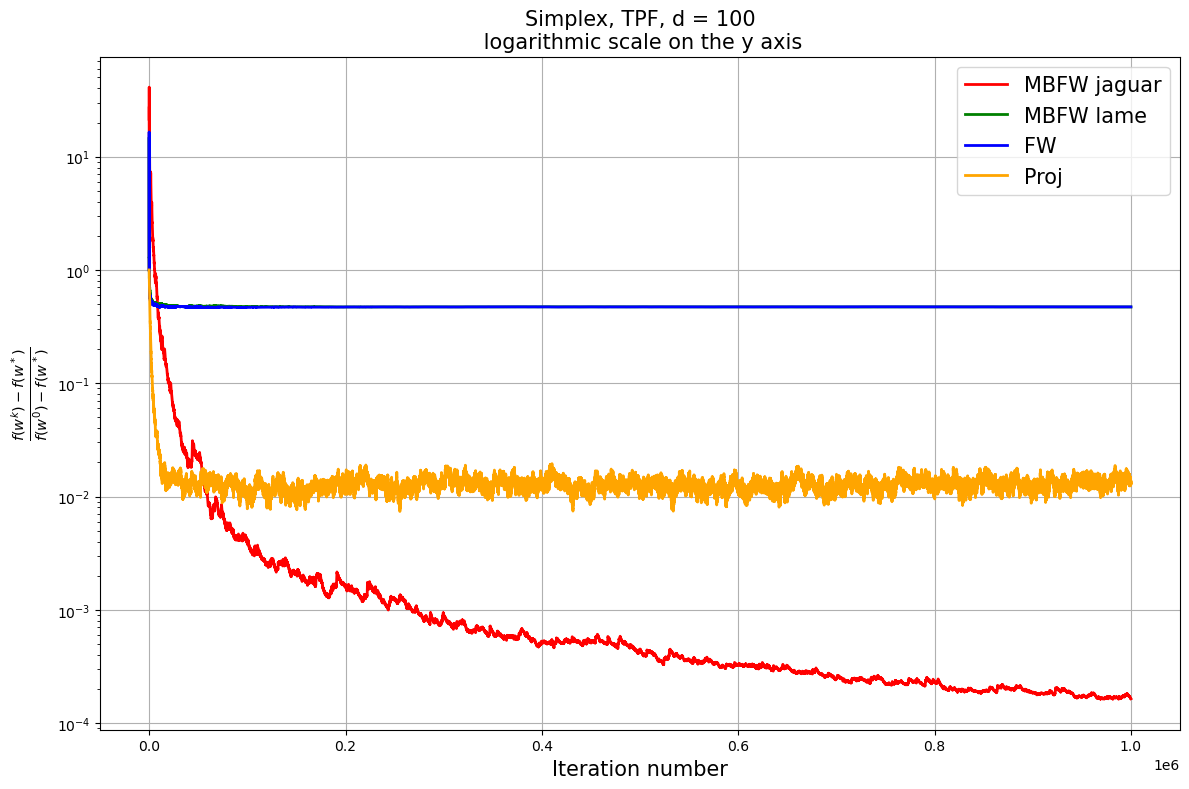

In [261]:
title = f"Simplex, TPF, d = {args['d']}"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_simp_tpf, errors_simp_tpf, y_label=y_label,
                     labels=labels_simp_tpf, title=title, markers=[None]*100)

# OPF

In [363]:
reload(optimizers)
title = ''

args['max_steps'] = 2 * 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['sega'] = True
args['prob'] = 0
args['y_k'] = np.zeros(args['d'])
args['grad_curr'] = np.zeros(args['d'])
args['h'] = np.zeros(args['d'])

Q = 'l1_ball'
jaguar = optimizers.get_grad_opf_jaguar
lame = optimizers.get_grad_opf_lame
name = 'OPF'

w_0 = w_0_l1
R_0 = R_0_l1
w_sol = w_true_sol_l1

mbfw_jaguar = optimizers.MBFWOptimizer(f, jaguar, x_0 = w_0, 
                                         step = fw_step, args = args)
mbfw_lame = optimizers.MBFWOptimizer(f, lame, x_0 = w_0, 
                                         step = fw_step, args = args)
fw = optimizers.FWOptimizer(f, lame, x_0 = w_0, 
                                         step = fw_step, args = args)
proj = optimizers.GDOptimizer(f, lame, x_0 = w_0, 
                                         step = const_gamma, args = args)
methods = [mbfw_jaguar, mbfw_lame, fw, proj]
names = ['MBFW jaguar', 'MBFW lame', 'FW', 'Proj']

iterations_l1_opf = []
errors_l1_opf = []
labels_l1_opf = []

for method, name in zip(methods, names):
                                  
    args['x_sol'] = w_sol
    args['set'] = Q
    if name == 'MBFW jaguar':
        args['sega'] = True
        args['batch_size'] = 1
    else:
        args['sega'] = False
        args['batch_size'] = 1
    if name == 'Proj':
        args['use_proj'] = True
    else:
        args['use_proj'] = False 
    if name == 'MD':
        args['c'] = 1
    else:
        args['c'] = 5000

    label = f'{name}'

    iterations, errors, _, _, _ = calculate(args, method, R_0, label, title)
    iterations_l1_opf.append(iterations)
    errors_l1_opf.append(errors)
    labels_l1_opf.append(label)

100%|█████████████| 20000/20000 [00:05<00:00, 3618.63it/s]


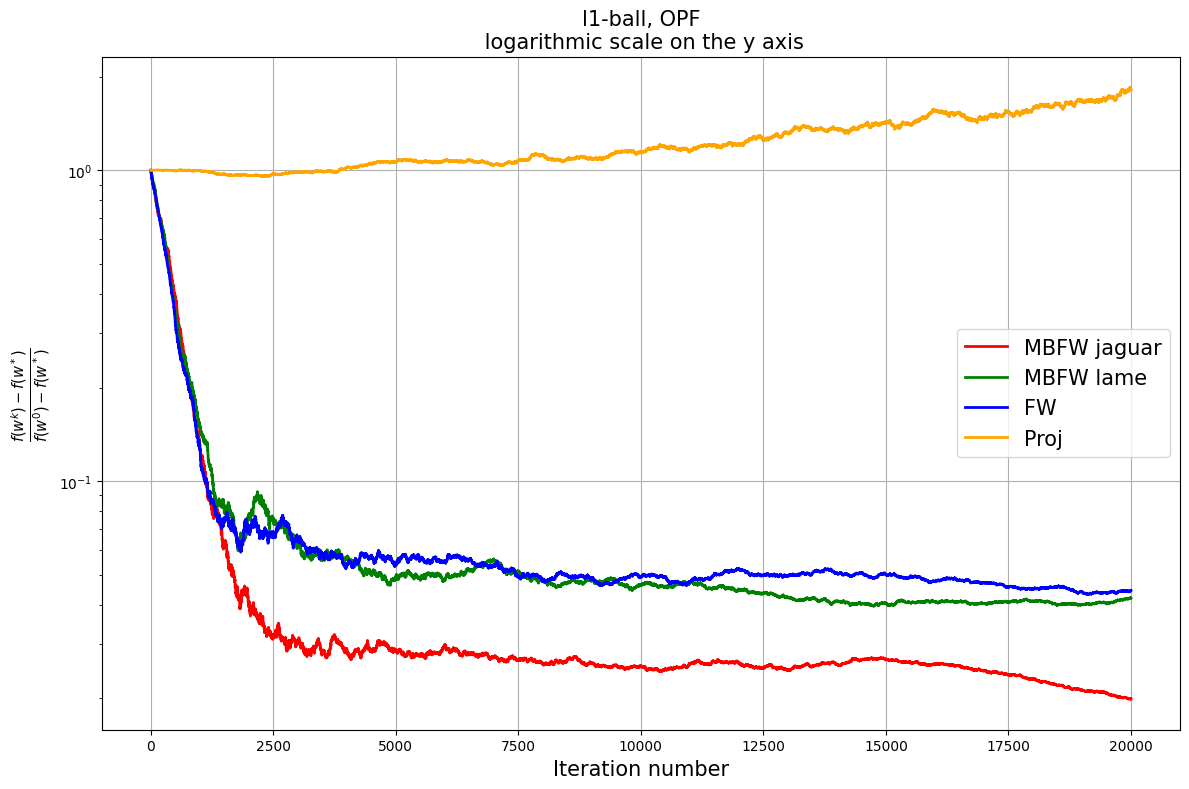

In [364]:
title = "l1-ball, OPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_l1_opf, errors_l1_opf, y_label=y_label,
                     labels=labels_l1_opf, title=title, markers=[None]*100)

In [354]:
def fw_step(k, func, nabla_f, x_curr, args):
    if 2 / (k + 3) > 1 / args['L']:
        return 1 / args['L']
    else:
        return 2 / (k + 3)

In [361]:
reload(optimizers)
title = ''

args['max_steps'] = 2 * 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['sega'] = True
args['prob'] = 0
args['y_k'] = np.zeros(args['d'])
args['grad_curr'] = np.zeros(args['d'])
args['h'] = np.zeros(args['d'])

Q = 'l2_ball'
jaguar = optimizers.get_grad_opf_jaguar
lame = optimizers.get_grad_opf_lame
name = 'OPF'

w_0 = w_0_l2
R_0 = R_0_l2
w_sol = w_true_sol_l2

mbfw_jaguar = optimizers.MBFWOptimizer(f, jaguar, x_0 = w_0, 
                                         step = fw_step, args = args)
mbfw_lame = optimizers.MBFWOptimizer(f, lame, x_0 = w_0, 
                                         step = fw_step, args = args)
fw = optimizers.FWOptimizer(f, lame, x_0 = w_0, 
                                         step = fw_step, args = args)
proj = optimizers.GDOptimizer(f, lame, x_0 = w_0, 
                                         step = const_gamma, args = args)
methods = [mbfw_jaguar, mbfw_lame, fw, proj]
names = ['MBFW jaguar', 'MBFW lame', 'FW', 'Proj']

iterations_l2_opf = []
errors_l2_opf = []
labels_l2_opf = []

for method, name in zip(methods, names):
                                  
    args['x_sol'] = w_sol
    args['set'] = Q
    if name == 'MBFW jaguar':
        args['sega'] = True
    else:
        args['sega'] = False
        
    if name == 'Proj':
        args['use_proj'] = True
    else:
        args['use_proj'] = False 
    if name == 'MD':
        args['c'] = 1
    else:
        args['c'] = 20000

    label = f'{name}'

    iterations, errors, _, _, _ = calculate(args, method, R_0, label, title)
    iterations_l2_opf.append(iterations)
    errors_l2_opf.append(errors)
    labels_l2_opf.append(label)

100%|█████████████| 20000/20000 [00:04<00:00, 4898.40it/s]


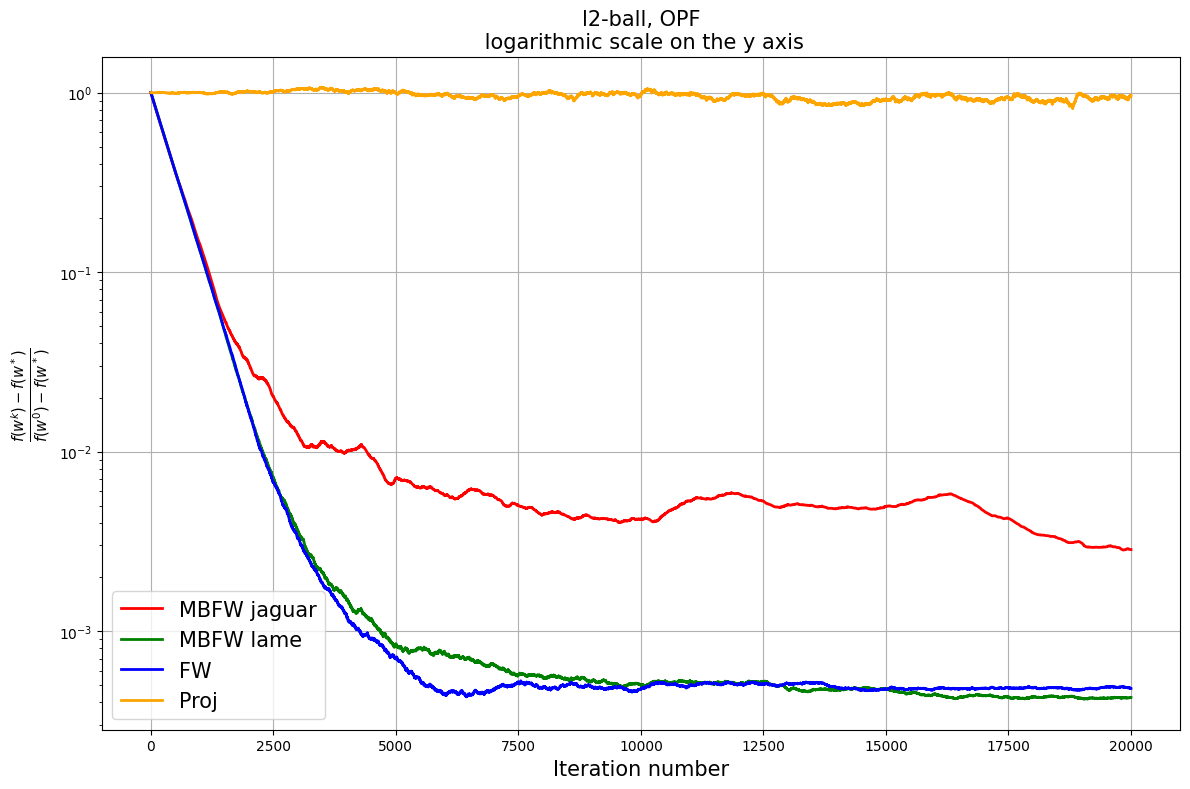

In [362]:
title = "l2-ball, OPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_l2_opf, errors_l2_opf, y_label=y_label,
                     labels=labels_l2_opf, title=title, markers=[None]*100)

In [349]:
def fw_step(k, func, nabla_f, x_curr, args):
    if 2 / (k + 3) > 1 / args['L']:
        return 1 / args['L']
    else:
        return 2 / (k + 3)

In [352]:
reload(optimizers)
title = ''

args['max_steps'] = 5 * 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['sega'] = True
args['prob'] = 0
args['y_k'] = np.zeros(args['d'])
args['grad_curr'] = np.zeros(args['d'])
args['h'] = np.zeros(args['d'])
args['norm'] = 1

Q = 'simplex'
jaguar = optimizers.get_grad_opf_jaguar
lame = optimizers.get_grad_opf_lame
name = 'TPF'

w_0 = w_0_simp
R_0 = R_0_simp
w_sol = w_true_sol_simp

mbfw_jaguar = optimizers.MBFWOptimizer(f, jaguar, x_0 = w_0, 
                                         step = fw_step, args = args)
mbfw_lame = optimizers.MBFWOptimizer(f, lame, x_0 = w_0, 
                                         step = fw_step, args = args)
fw = optimizers.FWOptimizer(f, lame, x_0 = w_0, 
                                         step = fw_step, args = args)
proj = optimizers.GDOptimizer(f, lame, x_0 = w_0, 
                                         step = const_gamma, args = args)

md = optimizers.MDOptimizer(f, lame, x_0 = w_0, 
                            step = const_gamma, args = args)

methods = [mbfw_jaguar, mbfw_lame, fw, proj, md]
names = ['MBFW jaguar', 'MBFW lame', 'FW', 'Proj']

iterations_simp_opf = []
errors_simp_opf = []
labels_simp_opf = []

for method, name in zip(methods, names):
                                  
    args['x_sol'] = w_sol
    args['set'] = Q
    if name == 'MBFW jaguar':
        args['sega'] = True
        args['batch_size'] = 1
    else:
        args['sega'] = False
        args['batch_size'] = 1
    if name == 'Proj':
        args['use_proj'] = True
    else:
        args['use_proj'] = False 
    if name == 'MD':
        args['c'] = 1000
    else:
        args['c'] = 5000

    label = f'{name}'

    iterations, errors, _, _, _ = calculate(args, method, R_0, label, title)
    iterations_simp_opf.append(iterations)
    errors_simp_opf.append(errors)
    labels_simp_opf.append(label)

100%|█████████████| 50000/50000 [00:16<00:00, 2978.47it/s]


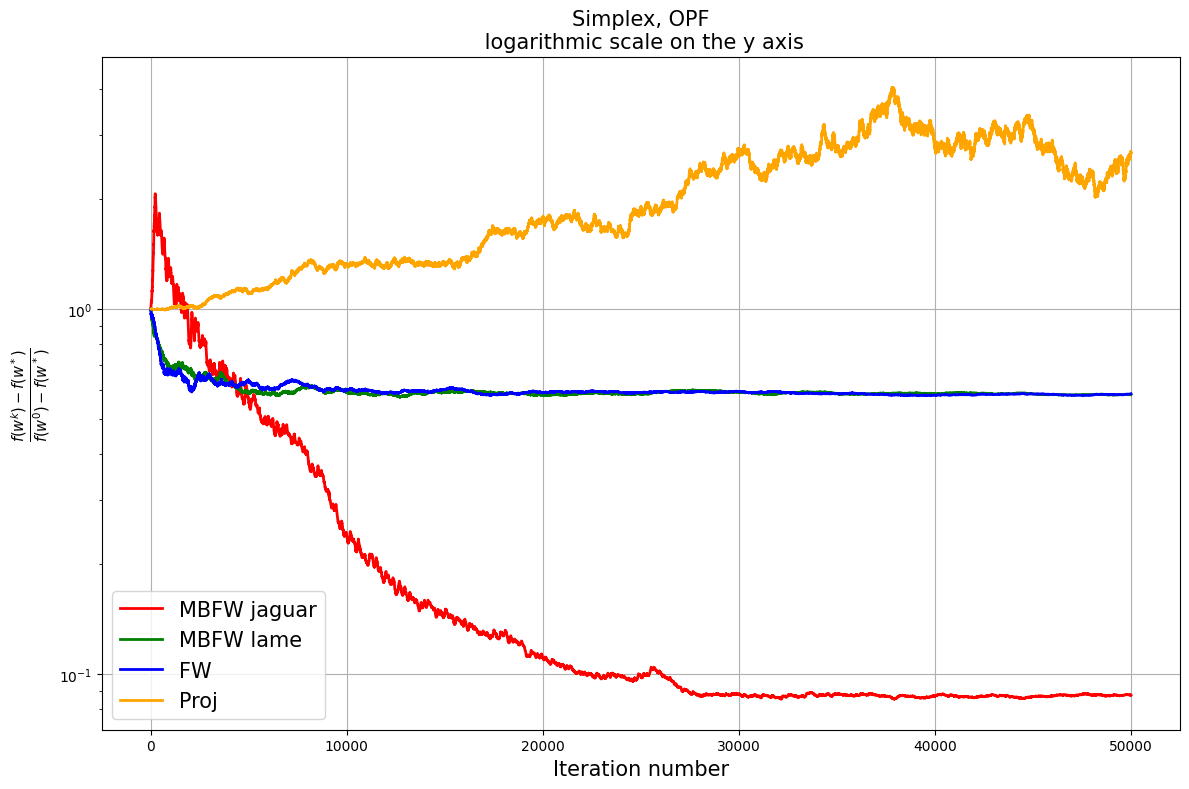

In [353]:
title = "Simplex, OPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_simp_opf, errors_simp_opf, y_label=y_label,
                     labels=labels_simp_opf, title=title, markers=[None]*100)